<a href="https://colab.research.google.com/github/leandrolrs18/ReconhecimentoDeMascara/blob/main/C%C3%B3pia_de_Covid_19_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google drive to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Step 1: Download face-mask-detector.zip** from [pyImageSearch](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/)

#**Step 2: Put it in your Google Drive**

#**Step 3: UnZip face-mask-detector.zip**

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/face-mask-detector.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/')

#Step 4: Change directory to face-mask-detector

In [ ]:
%cd /content/drive/My\ Drive/face-mask-detector

/content/drive/My Drive/face-mask-detector


In [ ]:
%pwd

'/content/drive/My Drive/face-mask-detector'

#**Step 5: Train Model**

In [ ]:
!python train_mask_detector.py --dataset dataset

2020-12-18 14:17:13.287567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
[INFO] loading images...
2020-12-18 14:18:50.472829: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-18 14:18:50.500474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-18 14:18:50.562681: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-18 14:18:50.562750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (811c5a338e25): /proc/driver/nvidia/version does not exist
2020-12-18 14:18:50.563307: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
9412608/9406464 [==============================] - 

#**Predict on Single Image**

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


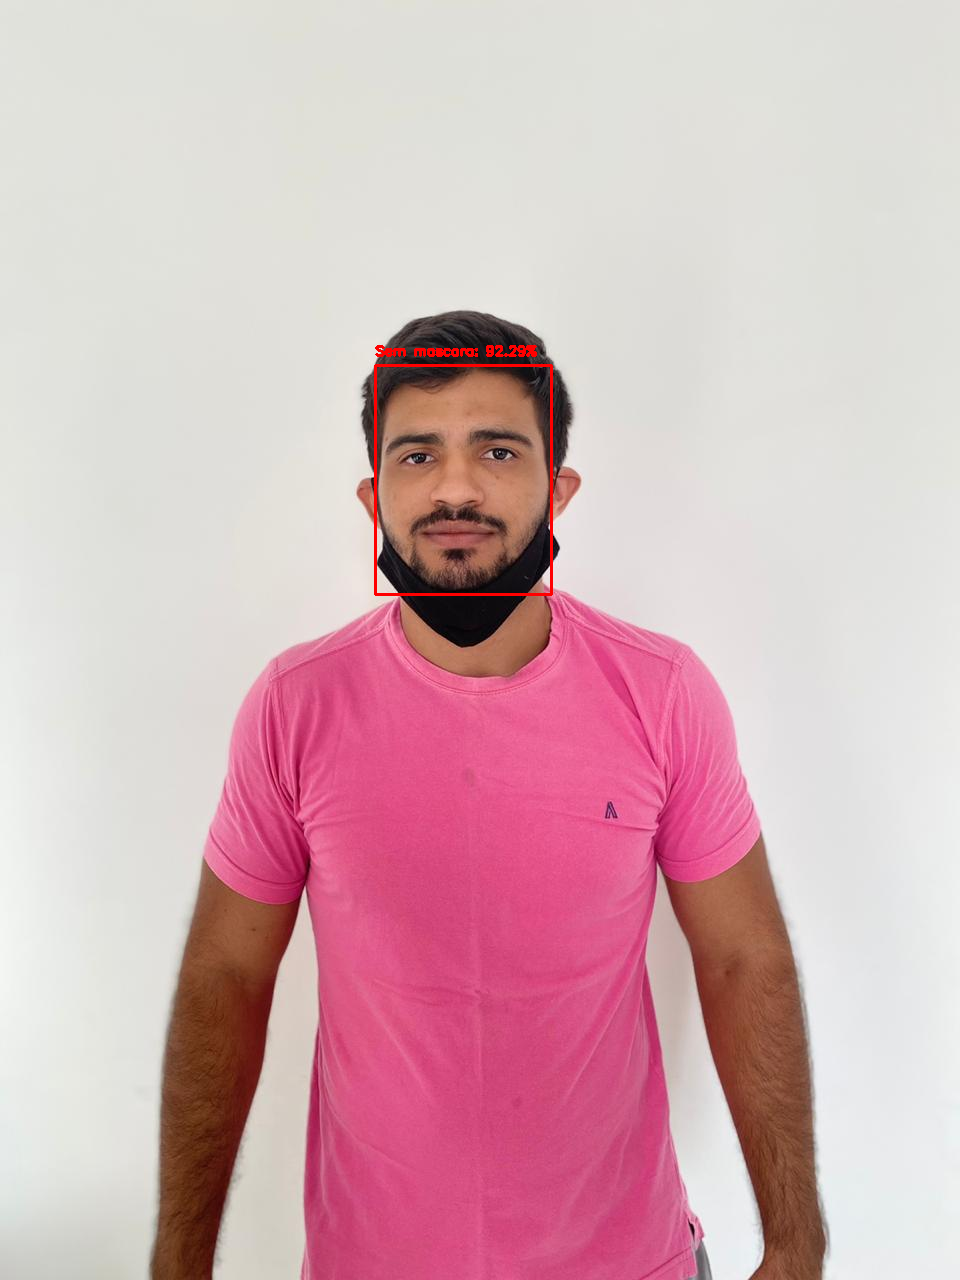

In [ ]:
# USAGE
# Give input image file path (check other paths also)

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns

input_file_path = "/content/drive/My Drive/face-mask-detector/examples/example_09.jpg"

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/My Drive/face-mask-detector/face_detector/deploy.prototxt"
weightsPath = "/content/drive/My Drive/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("mask_detector.model")

def process_images(input_file_path):
	# load the input image from disk, clone it, and grab the image spatial
  # dimensions
	image = cv2.imread(input_file_path)
	# orig = image.copy()
	(h, w) = image.shape[:2]

	# construct a blob from the image
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	print("[INFO] computing face detections...")
	net.setInput(blob)
	detections = net.forward()

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = image[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (64, 64))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# pass the face through the model to determine if the face
			# has a mask or not
			(mask, withoutMask) = model.predict(face)[0]

			# determine the class label and color we'll use to draw
			# the bounding box and text
			label = "Com mascara" if mask > withoutMask else "Sem mascara"
			color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

			# include the probability in the label
			label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

			# display the label and bounding box rectangle on the output
			# frame
			cv2.putText(image, label, (startX, startY - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
			cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

	# show the output image
	save_path = input_file_path.split(".",1)
	# print (save_path[0])
	# print (save_path[-1])
	cv2_imshow(image)
	# cv2.imwrite(save_path[0] + "_pred." + save_path[-1],image)

#start the process
process_images(input_file_path)

#**Predict on Multiple Images and make a MP4 video**

In [ ]:
# USAGE
# Give input images directory and output store directory

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns

# input_file_path = "/content/drive/My Drive/my_projects/face_mask_detector/testSet/pic7.jpg"
input_folder_path = "/content/drive/My Drive/face-mask-detector/examples/"
output_folder_path = "/content/drive/My Drive/face-mask-detector/test_OUTPUT.mp4"

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/My Drive/face-mask-detector/face_detector/deploy.prototxt"
weightsPath = "/content/drive/My Drive/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("mask_detector.model")

img_array = []

def process_images(input_file_path,count):
	# load the input image from disk, clone it, and grab the image spatial
  # dimensions
	image = cv2.imread(input_file_path)
	orig = image.copy()
	(h, w) = image.shape[:2]

	# construct a blob from the image
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	# print("[INFO] computing face detections...")
	net.setInput(blob)
	detections = net.forward()
	

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = image[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (64, 64))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# pass the face through the model to determine if the face
			# has a mask or not
			(mask, withoutMask) = model.predict(face)[0]

			# determine the class label and color we'll use to draw
			# the bounding box and text
			label = "Com mascara" if mask > withoutMask else "Sem mascara"
			color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

			# include the probability in the label
			label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

			# display the label and bounding box rectangle on the output
			# frame
			cv2.putText(image, label, (startX, startY - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
			cv2.rectangle(image, (startX, startY), (endX, endY), color, 5)

	# show the output image
	
	# cv2_imshow(image)
	height, width, layers = image.shape
	size = (width,height)
	img_array.append(image)
	# resized_frame = cv2.resize(image, (400, 225))
	count+=1
	# video.write(resized_frame)
	print ("\r[INFO] Count: {}".format(count),end='')
	return size, count
	# cv2.imwrite(save_path,image)

#start the process
x = os.listdir(input_folder_path)
sorted_path = natsorted(x, key=lambda y: y.lower())
count = 0
print ("[INFO] Total files: {}".format(len(x)))
for k in sorted_path: 
 file_path = input_folder_path + k
 print ("\r[INFO] File name: {}".format(file_path))
 size, count = process_images(file_path,count)

print ("\n[INFO] Total count/frames: {}".format(count))

#Saving all output frames as MP4 video
print ("[INFO] Saving video")
video = cv2.VideoWriter(output_folder_path, cv2.VideoWriter_fourcc(*'DIVX'), 1, size)
 
for i in range(len(img_array)):
    video.write(img_array[i])
video.release()
print ("[INFO] process complete.")


[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] Total files: 15
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_01.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_02.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_03.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_04.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_05.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_06.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_07.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_08.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_09.jpg
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_10.jpg
[INFO] File name: /content/drive/My Drive/face

#**Predict Using Video frames**

In [ ]:
# USAGE
# python detect_mask_video.py

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from imutils.video import FPS

from google.colab.patches import cv2_imshow
import pdb

#Input video file path
input_video_path = "/content/drive/My Drive/test_vid.mp4"

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		preds = maskNet.predict(faces)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/My Drive/face-mask-detector/face_detector/deploy.prototxt"
weightsPath = "/content/drive/My Drive/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model("mask_detector.model")

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
file_path = input_video_path.split(".",1)
vs = cv2.VideoCapture(input_video_path)
length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
time.sleep(2.0)

#checking video available or not
grabbed, frame_flip = vs.read()
if not(grabbed): print ("INPUT VIDEO NOT FOUND!")

# loop over the frames from the video stream
count = 0
img_array = []
while grabbed:
	(grabbed, frame) = vs.read()
	if not(grabbed): break
	if (count==0): print ("[INFO] processing started...")
	frame = imutils.resize(frame, width=400)
  
	#Optional step (comment if not needed)
	frame = cv2.rotate(frame, cv2.ROTATE_180)
	
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Com mascara" if mask > withoutMask else "Sem mascara"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
	
	# cv2_imshow(frame)
	height, width, layers = frame.shape
	size = (width,height)
	img_array.append(frame)
	print ("\r[INFO] Count: {}/{}".format(count, length),end='')
	count+=1

#Saving all output frames as MP4 video
print ("\n[INFO] Saving video")
video = cv2.VideoWriter(file_path[0] + "_OUTPUT." + file_path[-1], cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    video.write(img_array[i])
video.release()
print ("[INFO] process complete.")

# vs.stop()

#**Extract images from video (VIDEO -> IMAGES)**

In [ ]:
import cv2

# Opens the Video file
cap= cv2.VideoCapture('/content/drive/My Drive/test_vid.mp4')
i = 0
j = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)
    if ret == False:
        break
    cv2.imwrite('/content/drive/My Drive/face-mask-detector/examples/testImg/test_image_'+str(i)+'.jpg',frame)
    print ("\rCount: {}".format(i),end='')
    j+=1
    i+=1

# print ("\n[INFO] Next frame start with: {}".format(i))
print ("\n[INFO] Total frames: {}".format(j))
cap.release()
cv2.destroyAllWindows()

#**Make a movie from images (IMAGES -> VIDEO)**

In [ ]:
import cv2
import numpy as np
import glob
import pdb

input_folder_path = '/content/drive/My Drive/face-mask-detector/examples/testImg/'

#natural sorting
x = os.listdir(input_folder_path)
sorted_path = natsorted(x, key=lambda y: y.lower())
length = len(sorted_path)
count = 0
img_array = []
# for filename in glob.glob():
for filename in sorted_path:
    file_path = input_folder_path + filename
    img = cv2.imread(file_path)
    img = cv2.rotate(img, cv2.ROTATE_180)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    print ("\r[INFO] Count: {}/{}".format(count, length),end='')
    count+=1

#Saving all output frames as MP4 video
print ("\n[INFO] Saving video")
out = cv2.VideoWriter('/content/drive/My Drive/face-mask-detector/examples/testImg_OUTPUT.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print ("[INFO] process complete.")